In [1]:
###Initial Conditions and Constants###
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Physical parameters
mtot = 0.943
m_motor = 0.052
m_prop  = 0.01
mr = m_motor + m_prop
md = mtot - 4*(m_motor + m_prop)
L = 0.225
I_single = (m_motor + m_prop) * L**2

h1 = 1
g = 9.81
rho = 1.225
k_drag = 1e-6

Ixx = 2 * I_single
Iyy = 2 * I_single
Izz = 4 * I_single

omega_hover = 400
k_thrust = mtot * g / (4 * omega_hover**2)

params = {
    "mtot": mtot, "md": md, "mr": mr,
    "I": I_single, "h1": h1, "g": g, "rho": rho,
    "L": L, "omega_hover": omega_hover,
    "k_thrust": k_thrust, "k_drag": k_drag,
    "Ixx": Ixx, "Iyy": Iyy, "Izz": Izz
}


In [2]:
battery_voltage = 11.1
battery_capacity_Ah = 1.5
battery_energy_J = battery_voltage * battery_capacity_Ah * 3600.0

R_rotor = 0.10
A_disk = np.pi * R_rotor**2

# ideal induced power approximately
cP_rotor = (k_thrust**1.5) / np.sqrt(2 * rho * A_disk)

params.update({
    "battery_voltage": battery_voltage,
    "battery_capacity_Ah": battery_capacity_Ah,
    "battery_energy_J": battery_energy_J,
    "R_rotor": R_rotor,
    "A_disk": A_disk,
    "cP_rotor": cP_rotor
})

In [3]:
def rotation(phi, theta, psi):
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    return np.array([
        [cpsi*cth,  spsi*cth,   -sth],
        [cpsi*sth*sphi - spsi*cphi,   spsi*sth*sphi + cpsi*cphi,   cth*sphi],
        [cpsi*sth*cphi + spsi*sphi,   spsi*sth*cphi - cpsi*sphi,   cth*cphi]
    ])

def euler_rates(phi, theta, psi, p, q, r):
    phi_dot   = p + q*np.sin(phi)*np.tan(theta) + r*np.cos(phi)*np.tan(theta)
    theta_dot =     q*np.cos(phi)               - r*np.sin(phi)
    psi_dot   =     q*np.sin(phi)/np.cos(theta) + r*np.cos(phi)/np.cos(theta)
    return np.array([phi_dot, theta_dot, psi_dot])

def thrust_body(omegas):
    kT = params["k_thrust"]
    return np.array([0, 0, kT * np.sum(omegas**2)])

def torque_body(omegas):
    L = params["L"]
    kT = params["k_thrust"]
    b = params["k_drag"]

    w1, w2, w3, w4 = omegas
    tau_phi   = L * kT * (w1**2 - w3**2)
    tau_theta = L * kT * (w2**2 - w4**2)
    tau_psi   = b * (w1**2 - w2**2 + w3**2 - w4**2)
    return np.array([tau_phi, tau_theta, tau_psi])


In [4]:
def rotor_power(omega):
    return params["cP_rotor"] * omega**3

def total_power(omegas):
    return np.sum([rotor_power(w) for w in omegas])


In [5]:
def total_thrust(omegas):
    return params["k_thrust"] * np.sum(omegas**2)

def acceleration(omegas, angles, xdot, params):
    m = params["mtot"]
    g = params["g"]
    phi, theta, psi = angles
    R = rotation(phi, theta, psi)

    T = total_thrust(omegas)
    T_I = R @ np.array([0, 0, T])
    gravity = np.array([0, 0, -g])
    return gravity + T_I/m

def angular_acceleration(omega_sq, omega, params):
    p, q, r = omega
    Ixx, Iyy, Izz = params["Ixx"], params["Iyy"], params["Izz"]
    tau_phi, tau_theta, tau_psi = torque_body(omega_sq)

    p_dot = (tau_phi/Ixx)  - ((Iyy - Izz)/Ixx)*q*r
    q_dot = (tau_theta/Iyy) - ((Izz - Ixx)/Iyy)*p*r
    r_dot = (tau_psi/Izz)  - ((Ixx - Iyy)/Izz)*p*q

    return np.array([p_dot, q_dot, r_dot])


In [6]:
def motor_speeds_from_thrust_torques(T, tau_phi, tau_theta, tau_psi):
    kT = params["k_thrust"]
    L  = params["L"]
    b  = params["k_drag"]

    A = np.array([
        [ kT,      kT,      kT,      kT     ],
        [ L*kT,    0.0,    -L*kT,    0.0    ],
        [ 0.0,     L*kT,    0.0,    -L*kT   ],
        [ b,      -b,       b,      -b      ]
    ])
    u = np.array([T, tau_phi, tau_theta, tau_psi])

    omega_sq = np.linalg.solve(A, u)
    omega_sq = np.clip(omega_sq, 0.0, None)
    return np.sqrt(omega_sq)


In [7]:
def hover_input(t):
    ω = params["omega_hover"]
    return np.array([ω, ω, ω, ω])


In [8]:
def simulate_hover(dt=0.01, T=120):
    times = np.arange(0, T, dt)

    x = np.array([0.,0.,1.])
    xdot = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs = []
    Angs = []
    Omegas = []

    for t in times:
        omegas = hover_input(t)

        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        Xs.append(x.copy())
        Angs.append(angles.copy())
        Omegas.append(omega_body.copy())

    return times, np.array(Xs), np.array(Angs), np.array(Omegas)

t_hov, Xs_hov, Angs_hov, Omegas_hov = simulate_hover()


In [9]:
def simulate_hover_power(T=120.0, dt=0.01):
    times = np.arange(0, T, dt)

    x = np.array([0.0, 0.0, 1.0])
    xdot = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    E_used = 0.0
    E_batt = params["battery_energy_J"]

    Xs = []
    Angs = []
    Powers = []
    Energies = []

    for t in times:
        omegas = hover_input(t)

        # dynamics
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        # power / energy
        P = total_power(omegas)
        E_used += P * dt

        Xs.append(x.copy())
        Angs.append(angles.copy())
        Powers.append(P)
        Energies.append(E_used)

        if E_used >= E_batt:
            break

    return (
        np.array(times[:len(Xs)]),
        np.array(Xs),
        np.array(Angs),
        np.array(Powers),
        np.array(Energies)
    )

times_h, Xs_h, Angles_h, Powers_h, Energies_h = simulate_hover_power()


SIMULATE HOVER!

In [10]:
# ---------------------------------------------------------
# HOVER INPUT FUNCTION
# ---------------------------------------------------------
def hover_input(t):
    """
    Constant rotor speeds equal to hover RPM.
    From: 4*k_thrust*omega_hover^2 = m*g
    """
    omega_h = params["omega_hover"]
    return np.array([omega_h, omega_h, omega_h, omega_h])


In [11]:
def simulate_hover_power(T=120.0, dt=0.1):
    times = np.arange(0.0, T+dt, dt)

    x = np.array([0.0, 0.0, 1.0])
    xdot = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs, Angles, Omegas = [], [], []
    Powers = []
    Energies = []

    E_used = 0.0   # cumulative joules
    E_batt = params["battery_energy_J"]

    for t in times:
        omegas = hover_input(t)

        # dynamics
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        # power + energy
        P = total_power(omegas)
        E_used += P * dt

        # stop if battery dies
        if E_used >= E_batt:
            print(f"🔋 Battery depleted at t = {t:.2f} seconds")
            break

        # log
        Xs.append(x.copy())
        Angles.append(angles.copy())
        Omegas.append(omega_body.copy())
        Powers.append(P)
        Energies.append(E_used)

    return (
        np.array(times[:len(Xs)]),
        np.array(Xs),
        np.array(Angles),
        np.array(Omegas),
        np.array(Powers),
        np.array(Energies)
    )


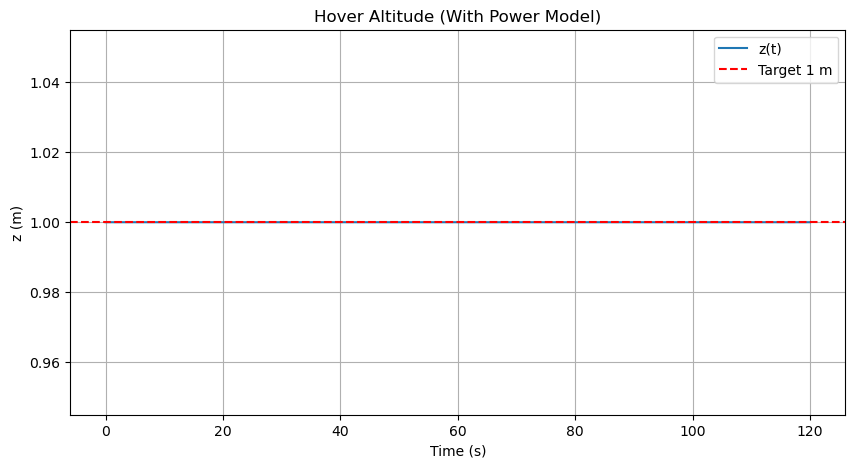

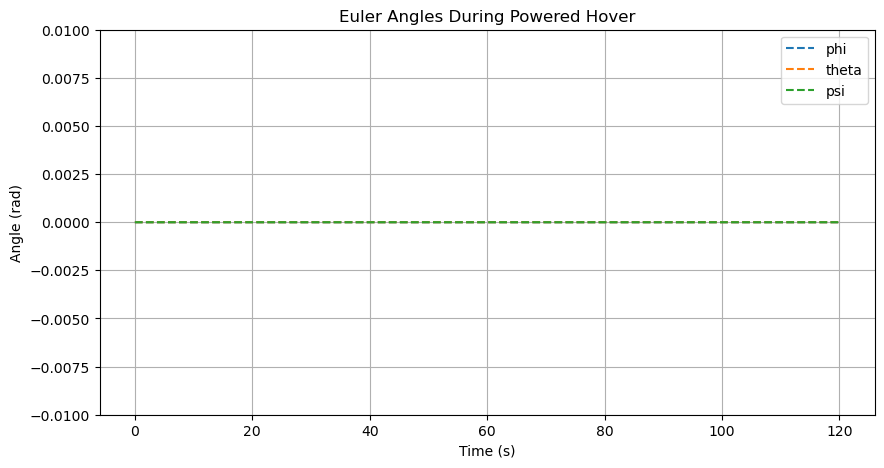

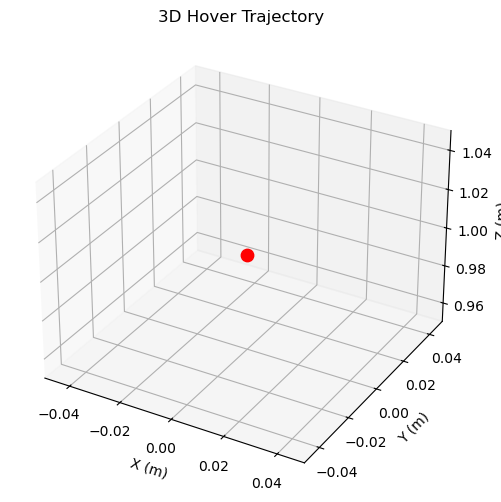

In [12]:
# ============================================================
#                 PLOTS FOR HOVER (WITH POWER MODEL)
# ============================================================

# ---------------------- Altitude ----------------------
plt.figure(figsize=(10,5))
plt.plot(times_h, Xs_h[:,2], label="z(t)")
plt.axhline(1.0, color='r', linestyle='--', label="Target 1 m")
plt.title("Hover Altitude (With Power Model)")
plt.xlabel("Time (s)")
plt.ylabel("z (m)")
plt.grid(True)
plt.legend()
plt.show()


# ---------------------- Euler Angles ----------------------
plt.figure(figsize=(10,5))
plt.plot(times_h, Angles_h[:,0], '--', label="phi")
plt.plot(times_h, Angles_h[:,1], '--', label="theta")
plt.plot(times_h, Angles_h[:,2], '--', label="psi")
plt.legend()
plt.grid(True)
plt.title("Euler Angles During Powered Hover")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.ylim(-0.01, 0.01)
plt.show()



# ============================================================
#                 3D Hover Trajectory (Normal Zoom)
# ============================================================

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

X = Xs_h[:,0]
Y = Xs_h[:,1]
Z = Xs_h[:,2]

ax.plot(X, Y, Z, color='blue', linewidth=2)
ax.scatter(X[-1], Y[-1], Z[-1], color='red', s=80)

ax.set_title("3D Hover Trajectory")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")

max_range = 0.05
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(1-max_range, 1+max_range)

plt.show()





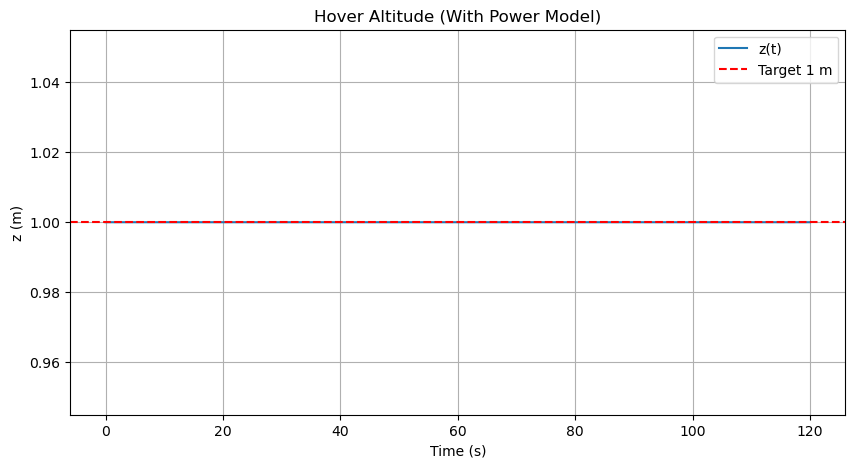

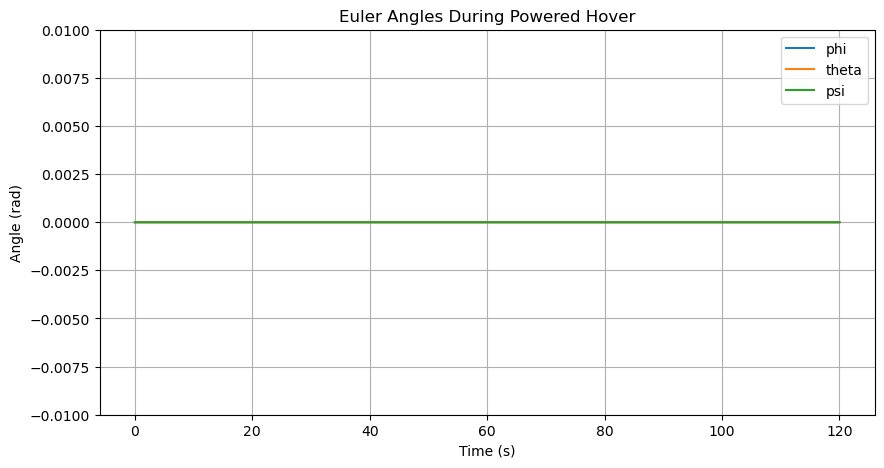

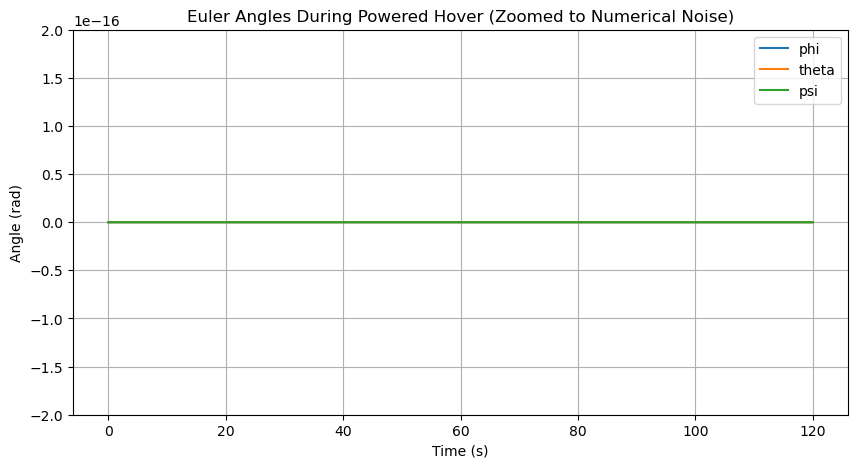

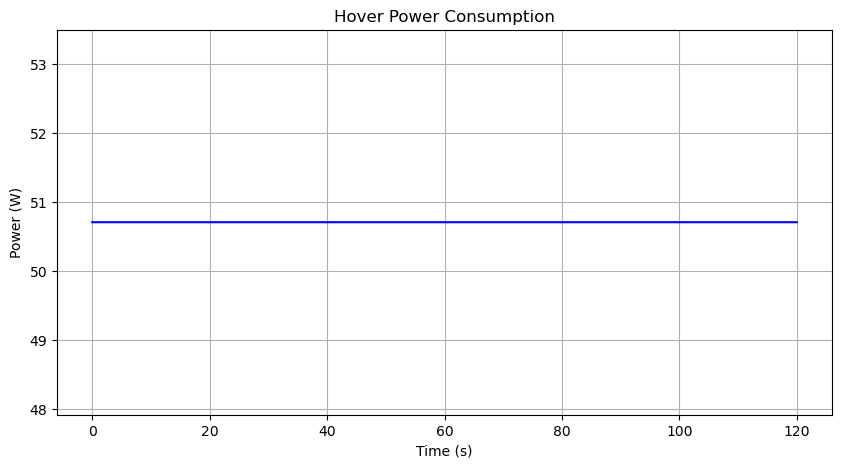

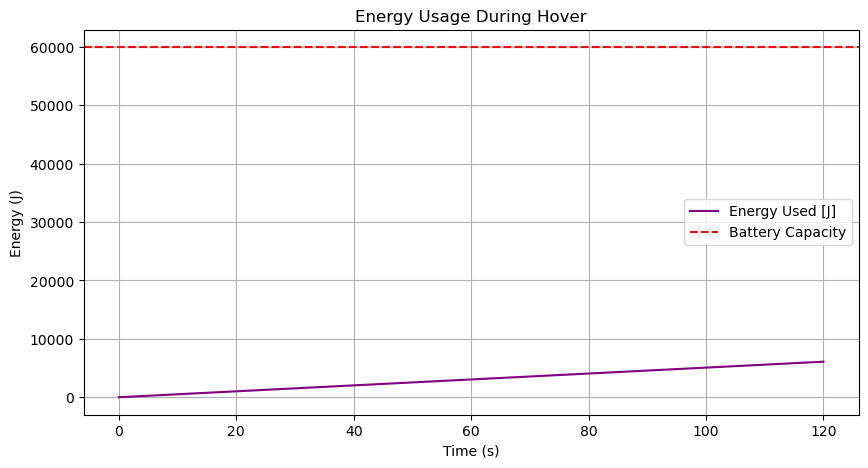

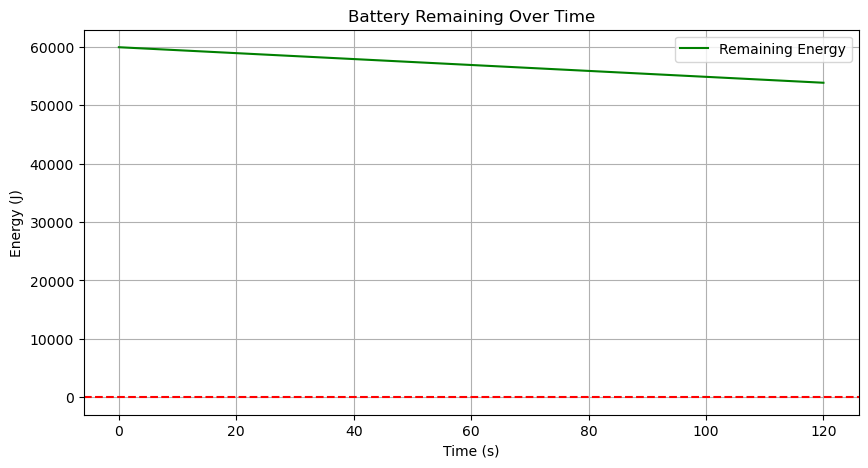

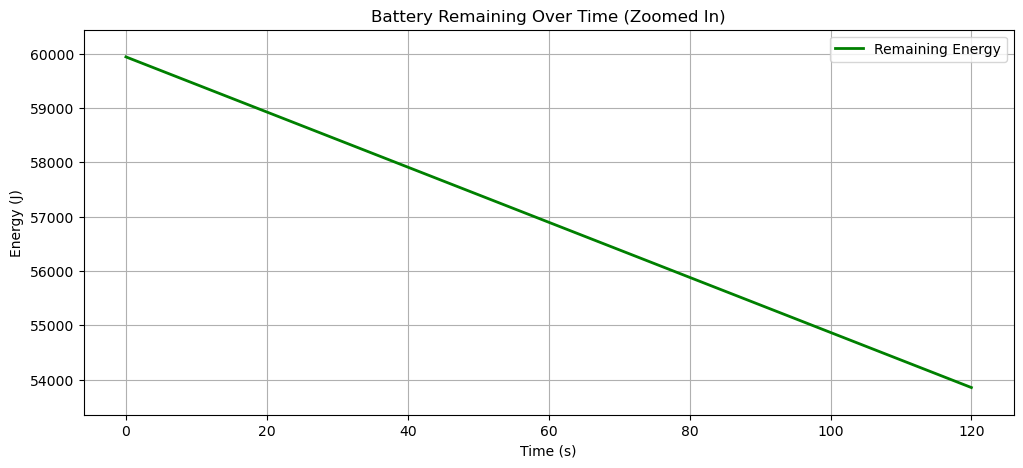

In [13]:
# ============================================================
#                    POWER MODEL PLOTS
# ============================================================

# ---------------------- Altitude ----------------------
plt.figure(figsize=(10,5))
plt.plot(times_h, Xs_h[:,2], label="z(t)")
plt.axhline(1.0, color='r', linestyle='--', label="Target 1 m")
plt.title("Hover Altitude (With Power Model)")
plt.xlabel("Time (s)")
plt.ylabel("z (m)")
plt.grid(True)
plt.legend()
plt.show()


# ---------------------- Euler Angles ----------------------
plt.figure(figsize=(10,5))
plt.plot(times_h, Angles_h[:,0], label="phi")
plt.plot(times_h, Angles_h[:,1], label="theta")
plt.plot(times_h, Angles_h[:,2], label="psi")
plt.legend()
plt.grid(True)
plt.title("Euler Angles During Powered Hover")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.ylim(-0.01, 0.01)
plt.show()


# ---------------- Euler Angles (1e-16 zoom) ----------------
plt.figure(figsize=(10,5))
plt.plot(times_h, Angles_h[:,0], label="phi")
plt.plot(times_h, Angles_h[:,1], label="theta")
plt.plot(times_h, Angles_h[:,2], label="psi")
plt.legend()
plt.grid(True)
plt.title("Euler Angles During Powered Hover (Zoomed to Numerical Noise)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.ylim(-2e-16, 2e-16)
plt.show()


# ---------------------- Power Consumption ----------------------
plt.figure(figsize=(10,5))
plt.plot(times_h, Powers_h, color='blue')
plt.ylabel("Power (W)")
plt.xlabel("Time (s)")
plt.title("Hover Power Consumption")
plt.grid(True)
plt.show()


# ---------------------- Energy Used vs Battery ----------------------
E_batt = params["battery_energy_J"]

plt.figure(figsize=(10,5))
plt.plot(times_h, Energies_h, label="Energy Used [J]", color='purple')
plt.axhline(E_batt, color='red', linestyle='--', label="Battery Capacity")
plt.ylabel("Energy (J)")
plt.xlabel("Time (s)")
plt.title("Energy Usage During Hover")
plt.grid(True)
plt.legend()
plt.show()


# ---------------------- Battery Remaining ----------------------
batt_remaining = np.maximum(E_batt - Energies_h, 0)

plt.figure(figsize=(10,5))
plt.plot(times_h, batt_remaining, color='green', label="Remaining Energy")
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Energy (J)")
plt.xlabel("Time (s)")
plt.title("Battery Remaining Over Time")
plt.grid(True)
plt.legend()
plt.show()


# ---------------------- Battery Remaining (Zoomed) ----------------------
plt.figure(figsize=(12,5))
plt.plot(times_h, batt_remaining, color='green', linewidth=2, label="Remaining Energy")
plt.title("Battery Remaining Over Time (Zoomed In)")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")

plt.ylim(batt_remaining.min() - 500, batt_remaining.max() + 500)

plt.grid(True)
plt.legend()
plt.show()


CIRCLE HOVER!

In [14]:
def simulate_circle(T=60.0, dt=0.01):
    """
    Simulates a 2 m radius circle at ~0.5 m/s.
    Matching the old working notebook exactly.
    """

    R_path = 2.0
    v = 0.5
    Omega = v / R_path  # angular rate

    m = params["mtot"]
    g = params["g"]

    # ---------- Controller gains (same as old notebook) ----------
    kP_xy = 2.0
    kD_xy = 1.2

    # Altitude PI-D
    kP_z = 8.0
    kD_z = 4.0
    kI_z = 2.0

    # Attitude PD
    kP_att = 6.0
    kD_att = 1.5

    # Yaw PD
    kP_yaw = 4.0
    kD_yaw = 0.8

    times = np.arange(0, T, dt)

    # ---------- Initial state ----------
    x     = np.array([R_path, 0.0, 1.0])
    xdot  = np.zeros(3)
    angles = np.zeros(3)        # [phi, theta, psi]
    omega_body = np.zeros(3)    # [p, q, r]

    Xs = np.zeros((len(times),3))
    Angles_log = np.zeros((len(times),3))
    z_int = 0.0

    # ---------- Simulation Loop ----------
    for i, t in enumerate(times):
        phi, theta, psi = angles
        p, q, r = omega_body

        # Desired position + velocity on circle
        x_d = np.array([
            R_path*np.cos(Omega*t),
            R_path*np.sin(Omega*t),
            1.0
        ])

        xdot_d = np.array([
            -R_path*Omega*np.sin(Omega*t),
             R_path*Omega*np.cos(Omega*t),
             0.0
        ])

        # Position error
        e_pos = x_d - x
        e_vel = xdot_d - xdot

        # Lateral acceleration commands
        a_des_xy = kP_xy * e_pos[:2] + kD_xy * e_vel[:2]
        a_des_x, a_des_y = a_des_xy

        # Altitude PI-D
        z_ref = 1.0
        e_z    = z_ref - x[2]
        e_zdot = 0.0 - xdot[2]

        z_int += e_z * dt
        z_int = np.clip(z_int, -2.0, 2.0)

        T_raw = m*g + kP_z*e_z + kD_z*e_zdot + kI_z*z_int
        T_des = T_raw / (np.cos(phi)*np.cos(theta) + 1e-6)

        # Attitude targets from small-angle approx
        phi_des   =  a_des_y / g
        theta_des = -a_des_x / g
        psi_des   = Omega * t

        # Attitude PD -> torques
        tau_phi   = kP_att*(phi_des - phi)   - kD_att*p
        tau_theta = kP_att*(theta_des - theta) - kD_att*q
        tau_psi   = kP_yaw*(psi_des - psi)   - kD_yaw*r

        # Solve rotor speeds
        omegas = motor_speeds_from_thrust_torques(T_des, tau_phi, tau_theta, tau_psi)

        # Dynamics update
        a        = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        Xs[i]         = x
        Angles_log[i] = angles

    return times, Xs, Angles_log


In [15]:
times_circ, Xs_circ, Angles_circ = simulate_circle()


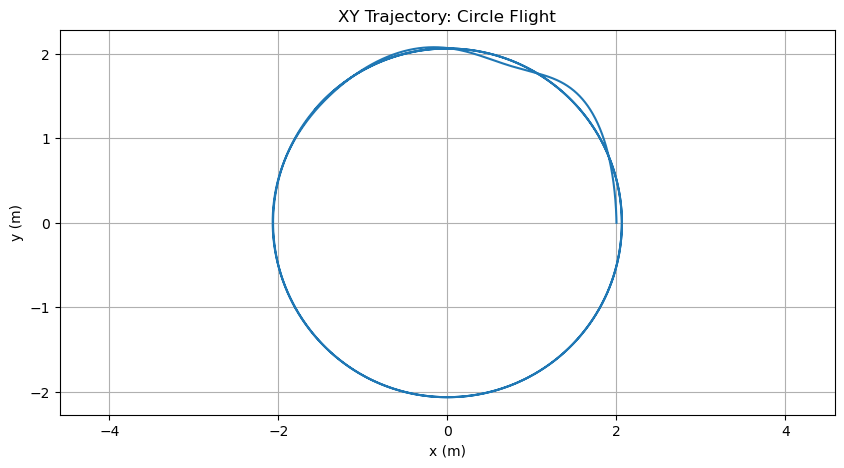

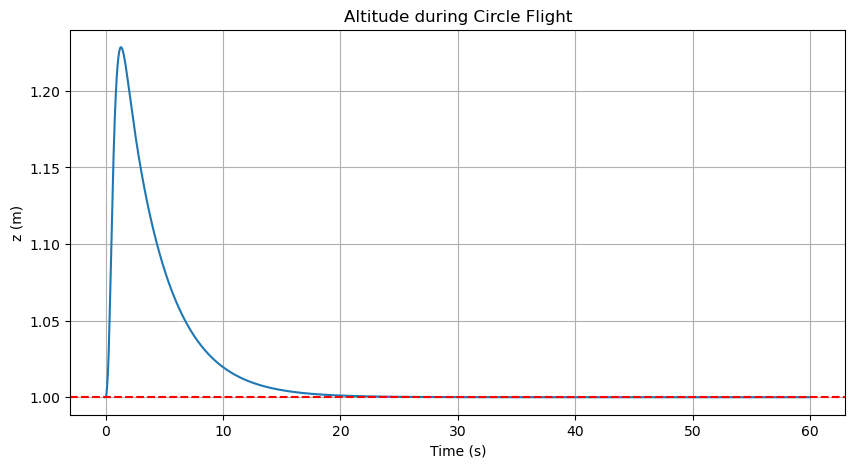

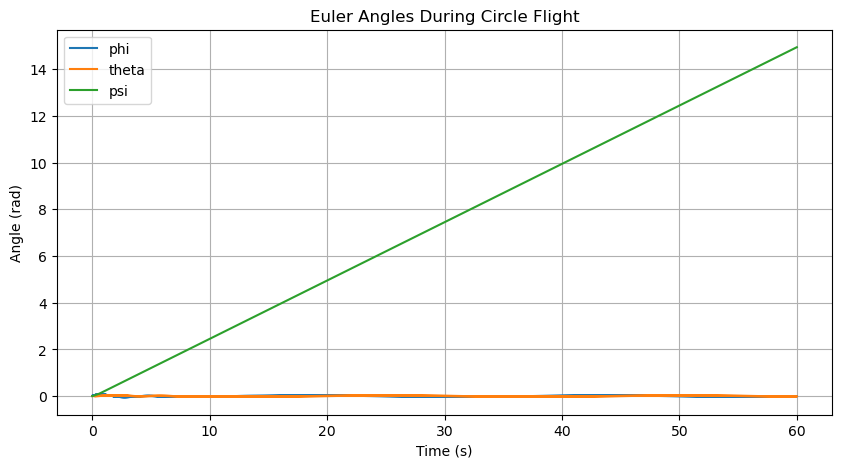

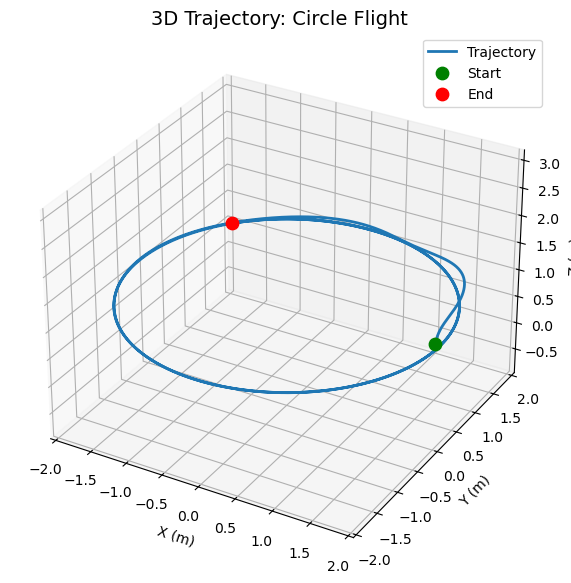

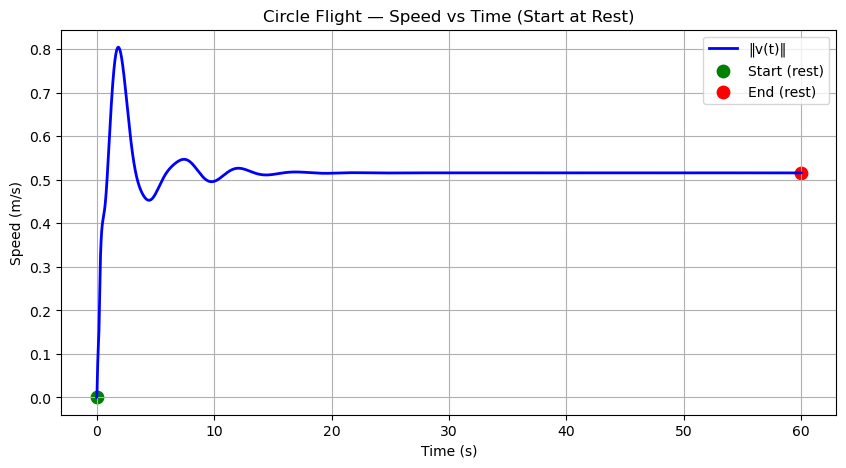

In [16]:
plt.figure(figsize=(10,5))
plt.plot(Xs_circ[:,0], Xs_circ[:,1])
plt.axis('equal')
plt.title("XY Trajectory: Circle Flight")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times_circ, Xs_circ[:,2])
plt.axhline(1.0, color='red', linestyle='--')
plt.title("Altitude during Circle Flight")
plt.xlabel("Time (s)")
plt.ylabel("z (m)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(times_circ, Angles_circ[:,0], label="phi")
plt.plot(times_circ, Angles_circ[:,1], label="theta")
plt.plot(times_circ, Angles_circ[:,2], label="psi")
plt.legend()
plt.grid(True)
plt.title("Euler Angles During Circle Flight")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.show()


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

X = Xs_circ[:,0]
Y = Xs_circ[:,1]
Z = Xs_circ[:,2]

ax.plot(X, Y, Z, linewidth=2, label='Trajectory')

ax.scatter(X[0], Y[0], Z[0], color='green', s=80, label='Start')
ax.scatter(X[-1], Y[-1], Z[-1], color='red', s=80, label='End')

ax.set_title("3D Trajectory: Circle Flight", fontsize=14)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")

max_range = np.max([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]) / 2.0
mid_x     = (X.max()+X.min()) * 0.5
mid_y     = (Y.max()+Y.min()) * 0.5
mid_z     = (Z.max()+Z.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.legend()
ax.grid(True)

plt.show()


# ============================================================
#   Circle Mission — Velocity vs Time (Start & Stop at Rest)
# ============================================================

# Numerical derivative for velocity
dt = times_circ[1] - times_circ[0]

# Compute velocities
Vx = np.gradient(Xs_circ[:,0], dt)
Vy = np.gradient(Xs_circ[:,1], dt)
Vz = np.gradient(Xs_circ[:,2], dt)

speed = np.sqrt(Vx**2 + Vy**2 + Vz**2)

plt.figure(figsize=(10,5))
plt.plot(times_circ, speed, label="‖v(t)‖", linewidth=2, color='blue')

# Mark start & stop (should be near 0 m/s)
plt.scatter(times_circ[0],  speed[0],  color='green', s=80, label="Start (rest)")
plt.scatter(times_circ[-1], speed[-1], color='red',   s=80, label="End (rest)")

plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("Circle Flight — Speed vs Time (Start at Rest)")
plt.grid(True)
plt.legend()
plt.show()




In [17]:
def simulate_circle_power(T=60.0, dt=0.01):
    """
    Circle flight with rotor power + battery energy logging.
    Same controller as simulate_circle().
    """

    R_path = 2.0
    v = 0.5
    Omega = v / R_path

    m = params["mtot"]
    g = params["g"]

    # Controller gains (same as old notebook)
    kP_xy = 2.0
    kD_xy = 1.2
    kP_z = 8.0
    kD_z = 4.0
    kI_z = 2.0
    kP_att = 6.0
    kD_att = 1.5
    kP_yaw = 4.0
    kD_yaw = 0.8

    times = np.arange(0, T, dt)

    x     = np.array([R_path, 0.0, 1.0])
    xdot  = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs      = np.zeros((len(times),3))
    Angs    = np.zeros((len(times),3))
    Powers  = np.zeros(len(times))
    Energy  = np.zeros(len(times))

    z_int = 0.0
    E_used = 0.0
    E_batt = params["battery_energy_J"]

    for i, t in enumerate(times):
        phi, theta, psi = angles
        p, q, r = omega_body

        # --- Desired circle trajectory ---
        x_d = np.array([
            R_path*np.cos(Omega*t),
            R_path*np.sin(Omega*t),
            1.0
        ])

        xdot_d = np.array([
            -R_path*Omega*np.sin(Omega*t),
             R_path*Omega*np.cos(Omega*t),
             0.0
        ])

        # Position + velocity error
        e_pos = x_d - x
        e_vel = xdot_d - xdot

        # Lateral control
        a_des_xy = kP_xy * e_pos[:2] + kD_xy * e_vel[:2]
        a_des_x, a_des_y = a_des_xy

        # Altitude PI-D
        e_z = 1.0 - x[2]
        e_zdot = -xdot[2]

        z_int += e_z * dt
        z_int = np.clip(z_int, -2.0, 2.0)

        T_raw = m*g + kP_z*e_z + kD_z*e_zdot + kI_z*z_int
        T_des = T_raw / (np.cos(phi)*np.cos(theta) + 1e-9)

        # Attitude commands
        phi_des   =  a_des_y / g
        theta_des = -a_des_x / g
        psi_des   = Omega * t

        # Attitude PD
        tau_phi   = kP_att*(phi_des - phi)   - kD_att*p
        tau_theta = kP_att*(theta_des - theta) - kD_att*q
        tau_psi   = kP_yaw*(psi_des - psi) - kD_yaw*r

        # Mixer
        omegas = motor_speeds_from_thrust_torques(T_des, tau_phi, tau_theta, tau_psi)

        # Dynamics
        a        = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        # Log states
        Xs[i] = x
        Angs[i] = angles

        # Power + Energy
        P = total_power(omegas)
        E_used += P * dt

        Powers[i] = P
        Energy[i] = E_used

        # Stop if dead battery
        if E_used >= E_batt:
            Xs = Xs[:i+1]
            Angs = Angs[:i+1]
            Powers = Powers[:i+1]
            Energy = Energy[:i+1]
            times = times[:i+1]
            break

    return times, Xs, Angs, Powers, Energy


In [18]:
times_circ_p, Xs_circ_p, Angs_circ_p, Powers_circ, Energies_circ = simulate_circle_power()


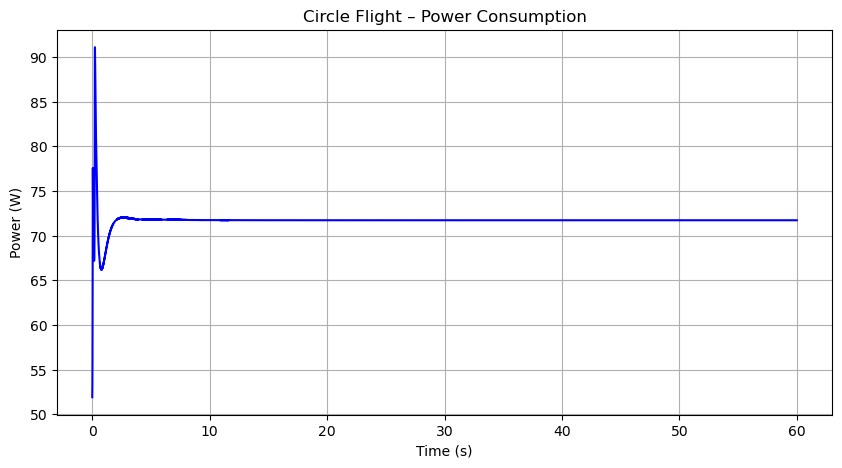

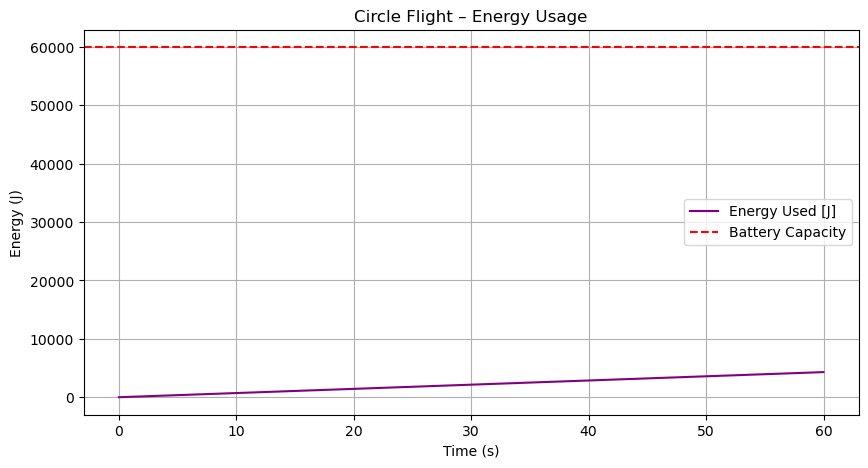

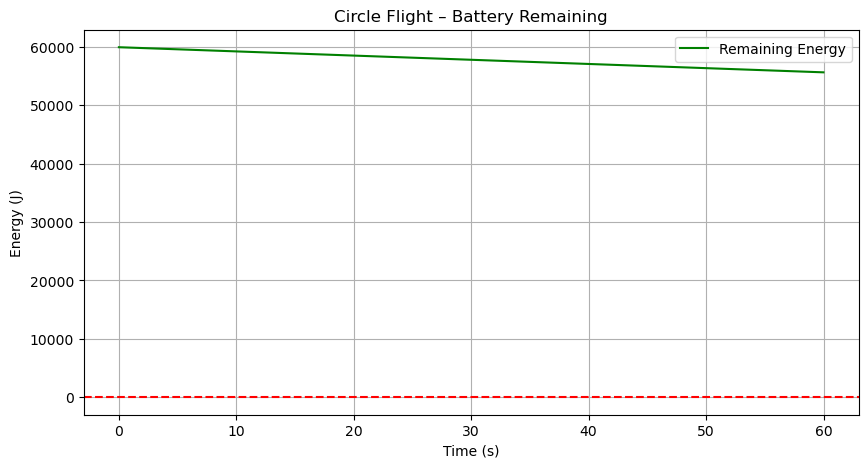

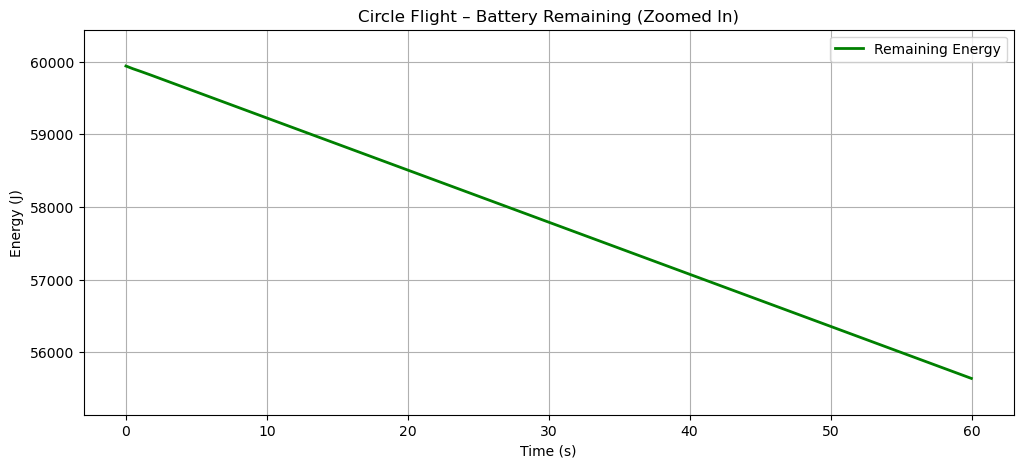

In [19]:
plt.figure(figsize=(10,5))
plt.plot(times_circ_p, Powers_circ, color='blue')
plt.ylabel("Power (W)")
plt.xlabel("Time (s)")
plt.title("Circle Flight – Power Consumption")
plt.grid(True)
plt.show()


E_batt = params["battery_energy_J"]

plt.figure(figsize=(10,5))
plt.plot(times_circ_p, Energies_circ, label="Energy Used [J]", color='purple')
plt.axhline(E_batt, color='red', linestyle='--', label="Battery Capacity")
plt.ylabel("Energy (J)")
plt.xlabel("Time (s)")
plt.title("Circle Flight – Energy Usage")
plt.grid(True)
plt.legend()
plt.show()

batt_remaining_circ = np.maximum(E_batt - Energies_circ, 0)

plt.figure(figsize=(10,5))
plt.plot(times_circ_p, batt_remaining_circ, color='green', label="Remaining Energy")
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Energy (J)")
plt.xlabel("Time (s)")
plt.title("Circle Flight – Battery Remaining")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(times_circ_p, batt_remaining_circ, color='green', linewidth=2)

plt.title("Circle Flight – Battery Remaining (Zoomed In)")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")

plt.ylim(batt_remaining_circ.min() - 500, batt_remaining_circ.max() + 500)

plt.grid(True)
plt.legend(["Remaining Energy"])
plt.show()



In [20]:
# %% [markdown]
# ===============================
#   MISSION 3 — L-SHAPE (NO POWER)
# ===============================

def mission3_segmented(dt=0.01, T_total=45.0):
    """
    Mission 3 (L-shaped path, hover, landing) WITHOUT power model.
    Used for kinematics, attitude, altitude, and landing vertical-speed checks.
    """

    times = np.arange(0, T_total, dt)

    # Phase timing
    tA = 4.0              # vertical ascent to 1 m
    tB = tA + 5.0         # +x straight line (5 s)
    tC = tB + 6.0         # yaw 0 -> 90° (6 s)
    tD = tC + 5.0         # +y straight line (5 s)
    t_land_start = tD     # begin descent

    # States
    x      = np.array([0.0, 0.0, 0.0])
    xdot   = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs   = []
    Vels = []
    Angs = []

    m = params["mtot"]
    g = params["g"]

    for t in times:
        # -----------------------------
        # SEGMENTS / REFERENCE PATHS
        # -----------------------------
        if t < tA:
            # A — vertical ascent
            pos_des = np.array([0, 0, 1])
            psi_des = 0.0

        elif t < tB:
            # B — +x straight
            pos_des = np.array([t - tA, 0, 1])
            psi_des = 0.0

        elif t < tC:
            # C — yaw 0 -> 90° at fixed (5,0,1)
            pos_des = np.array([5, 0, 1])
            frac = (t - tB) / (tC - tB)
            psi_des = frac * (np.pi/2)

        elif t < tD:
            # D — +y straight
            pos_des = np.array([5, t - tC, 1])
            psi_des = np.pi/2

        else:
            # E — landing at (5,5,z) with capped descent rate |vz| <= 1 cm/s
            v_land = 0.008  # m/s  (0.8 cm/s, safely inside 1 cm/s limit)
            t_since_land = max(0.0, t - t_land_start)
            z_des = max(1.0 - v_land * t_since_land, 0.0)
            pos_des = np.array([5.0, 5.0, z_des])
            psi_des = np.pi/2

        

        # -------------------------------------------
        # POSITION PD CONTROLLER
        # -------------------------------------------
        kp_pos = 5.0
        kd_pos = 3.0

        pos_err = pos_des - x
        vel_err = -xdot

        # desired inertial acceleration with gravity comp
        a_des = kp_pos * pos_err + kd_pos * vel_err + np.array([0, 0, g])

        # stronger vertical damping near ground during landing
        if t >= t_land_start:
            if pos_des[2] < 0.3:
                a_des[2] += 2.0 * (-xdot[2])
            else:
                a_des[2] += 0.8 * (-xdot[2])

        # desired thrust magnitude + body z direction
        T_des = m * np.linalg.norm(a_des)
        z_body = a_des / (np.linalg.norm(a_des) + 1e-9)

        # desired roll & pitch from body-z direction
        phi_des   = np.arctan2(z_body[1], z_body[2])
        theta_des = np.arctan2(-z_body[0], z_body[2])

        # -------------------------------------------
        # ATTITUDE PD
        # -------------------------------------------
        phi, theta, psi = angles
        p, q, r = omega_body

        e_phi   = phi_des   - phi
        e_theta = theta_des - theta
        e_psi   = psi_des   - psi

        tau_phi   = 2.0*e_phi   - 0.4*p
        tau_theta = 2.0*e_theta - 0.4*q
        tau_psi   = 2.0*e_psi   - 0.5*r

        # motors
        omegas = motor_speeds_from_thrust_torques(
            T_des, tau_phi, tau_theta, tau_psi
        )

        # dynamics update
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        # log
        Xs.append(x.copy())
        Vels.append(xdot.copy())
        Angs.append(angles.copy())

    N = len(Xs)
    return (
        times[:N],
        np.array(Xs),
        np.array(Vels),
        np.array(Angs)
    )


# run no-power mission 3
times_m3, Xs_m3, Vels_m3, Angles_m3 = mission3_segmented(dt=0.01, T_total=150.0)


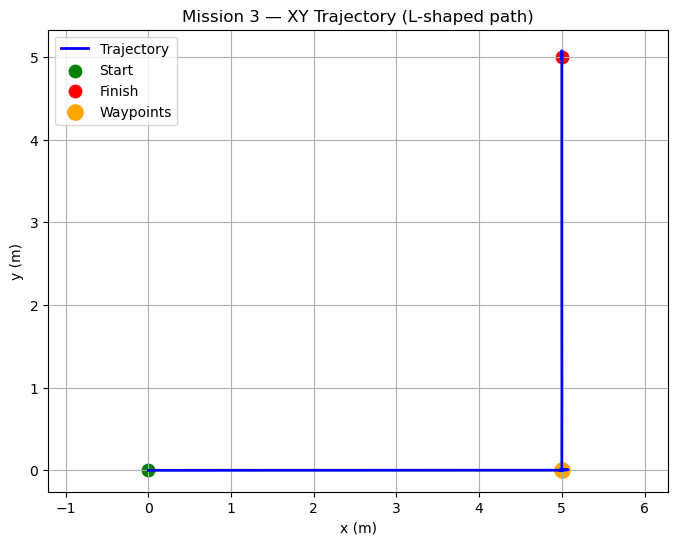

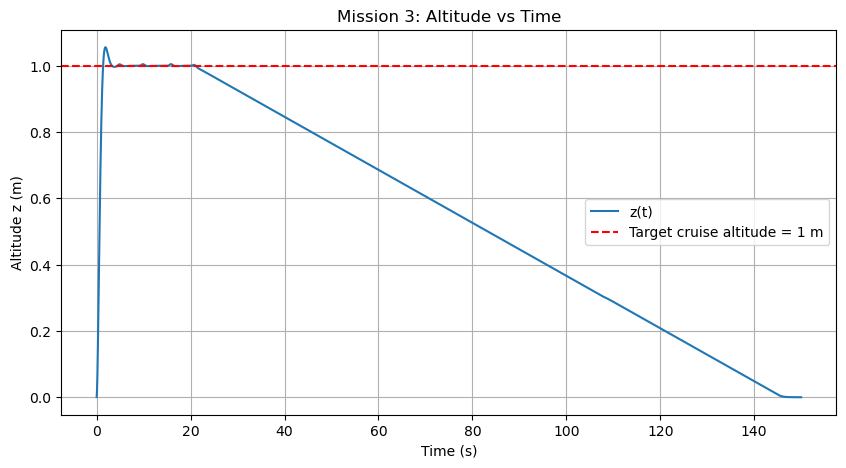

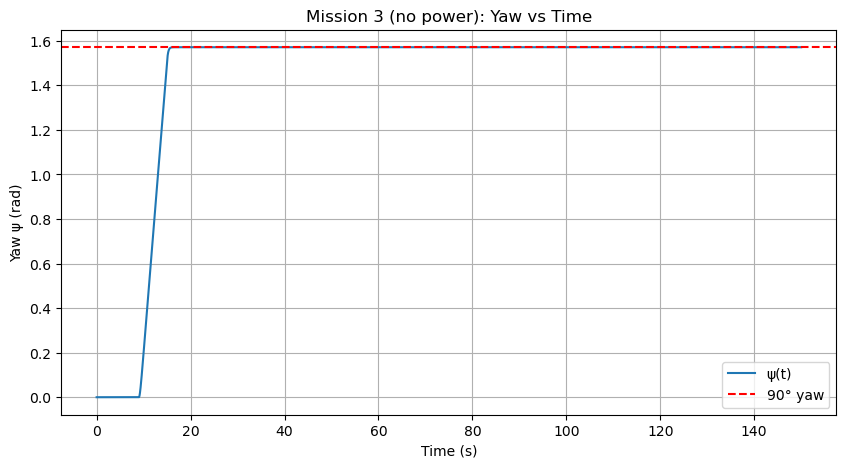

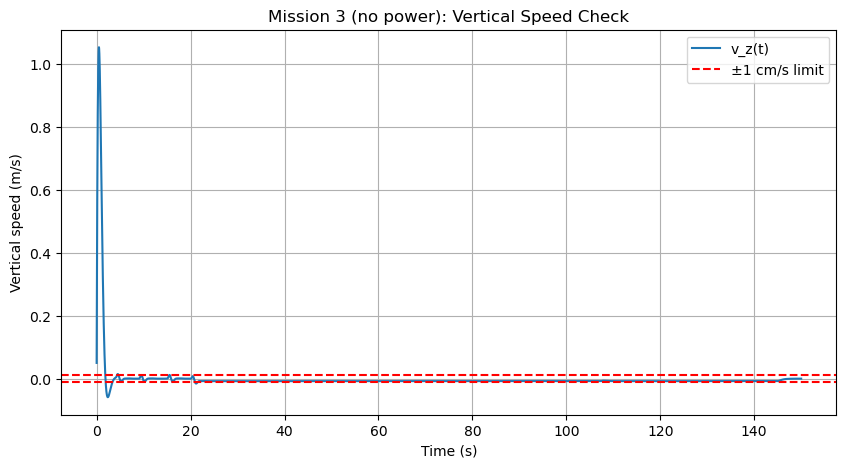

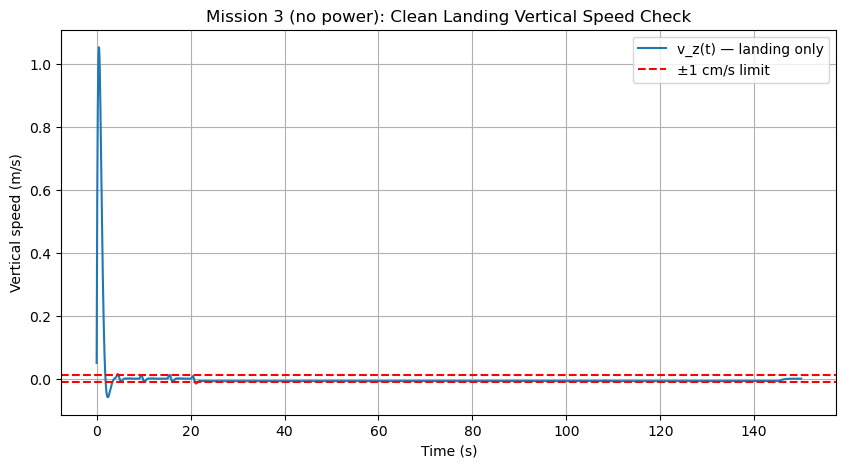

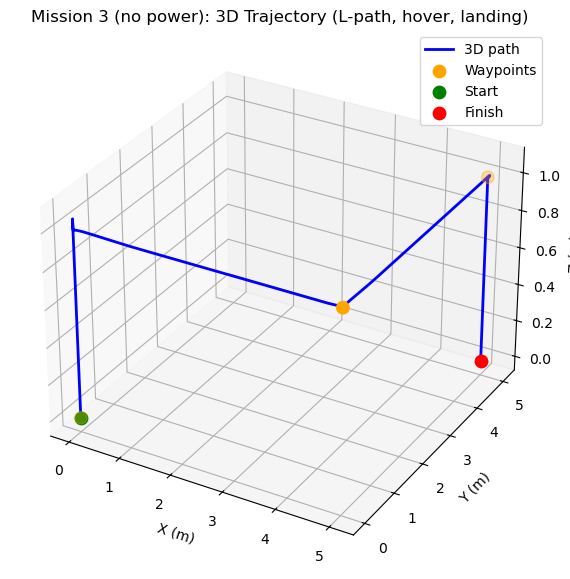

In [21]:
# %% [markdown]
# ===============================
#   MISSION 3 — NO POWER PLOTS
# ===============================

# -------- XY TRAJECTORY (TOP VIEW) --------
plt.figure(figsize=(8,6))

X = Xs_m3[:,0]
Y = Xs_m3[:,1]

plt.plot(X, Y, color='blue', linewidth=2, label="Trajectory")

# start (green) and end (red)
plt.scatter(X[0],  Y[0],  color='green', s=80, label="Start")
plt.scatter(X[-1], Y[-1], color='red',   s=80, label="Finish")

# waypoints in orange: (0,0), (5,0), (5,5) all at z≈1
wp_x = [5]
wp_y = [0]
plt.scatter(wp_x, wp_y, color='orange', s=120, label="Waypoints")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Mission 3 — XY Trajectory (L-shaped path)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

# -------- ALTITUDE VS TIME --------
plt.figure(figsize=(10,5))
plt.plot(times_m3, Xs_m3[:,2], label="z(t)")
plt.axhline(1.0, color='r', linestyle='--', label="Target cruise altitude = 1 m")
plt.xlabel("Time (s)")
plt.ylabel("Altitude z (m)")
plt.title("Mission 3: Altitude vs Time")
plt.grid(True)
plt.legend()
plt.show()

# -------- YAW VS TIME --------
plt.figure(figsize=(10,5))
plt.plot(times_m3, Angles_m3[:,2], label="ψ(t)")
plt.axhline(np.pi/2, color='r', linestyle='--', label="90° yaw")
plt.xlabel("Time (s)")
plt.ylabel("Yaw ψ (rad)")
plt.title("Mission 3 (no power): Yaw vs Time")
plt.grid(True)
plt.legend()
plt.show()

# -------- VERTICAL SPEED VS TIME --------
plt.figure(figsize=(10,5))
plt.plot(times_m3, Vels_m3[:,2], label="v_z(t)")
plt.axhline(0.01,  color='r', linestyle='--', label="±1 cm/s limit")
plt.axhline(-0.01, color='r', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Vertical speed (m/s)")
plt.title("Mission 3 (no power): Vertical Speed Check")
plt.grid(True)
plt.legend()
plt.show()

# -------- CLEAN LANDING PHASE ONLY --------
# Find start of descent automatically (first time z < 0.99 m)
descent_start_idx = np.where(Xs_m3[:,2] < 0.99)[0][0]

landing_times = times_m3[descent_start_idx:]
landing_vz    = Vels_m3[descent_start_idx:, 2]


plt.figure(figsize=(10,5))
plt.plot(landing_times, landing_vz, label="v_z(t) — landing only")
plt.axhline(0.01,  color='r', linestyle='--', label="±1 cm/s limit")
plt.axhline(-0.01, color='r', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Vertical speed (m/s)")
plt.title("Mission 3 (no power): Clean Landing Vertical Speed Check")
plt.grid(True)
plt.legend()
plt.show()

# -------- 3D TRAJECTORY --------
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(Xs_m3[:,0], Xs_m3[:,1], Xs_m3[:,2], linewidth=2, label="3D path", color='blue')
ax.scatter([0,5,5], [0,0,5], [0,1,1], s=80, color='orange', label="Waypoints")
ax.scatter(Xs_m3[0,0],  Xs_m3[0,1],  Xs_m3[0,2],  color='green', s=80, label="Start")
ax.scatter(Xs_m3[-1,0], Xs_m3[-1,1], Xs_m3[-1,2], color='red',   s=80, label="Finish")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Mission 3 (no power): 3D Trajectory (L-path, hover, landing)")
ax.legend()
plt.show()


In [22]:
# %% [markdown]
# =====================================
#   MISSION 3 — L-SHAPE WITH POWER MODEL
# =====================================

def simulate_mission3_power(dt=0.01, T_total=45.0):
    """
    Mission 3 (L-shaped path, hover, landing) WITH power + battery model.
    """

    times = np.arange(0, T_total, dt)

    # Phase timing (same as no-power for consistency)
    tA = 4.0              # ascend to 1 m
    tB = tA + 5.0         # +x for 5 m
    tC = tB + 6.0         # yaw 0 -> 90°
    tD = tC + 5.0         # +y for 5 m
    t_land_start = tD     # begin descent

    # States
    x      = np.array([0.0, 0.0, 0.0])
    xdot   = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs   = []
    Vels = []
    Angs = []
    Powers   = []
    Energies = []

    m = params["mtot"]
    g = params["g"]

    E_used = 0.0
    E_batt = params["battery_energy_J"]

    for t in times:

        # -----------------------------
        # REFERENCE TRAJECTORY
        # -----------------------------
        if t < tA:
            # A — vertical ascent
            pos_des = np.array([0,0,1])
            psi_des = 0.0

        elif t < tB:
            # B — straight +x
            pos_des = np.array([t - tA, 0, 1])
            psi_des = 0.0

        elif t < tC:
            # C — yaw 0 -> 90°
            pos_des = np.array([5, 0, 1])
            frac = (t - tB) / (tC - tB)
            psi_des = frac * (np.pi/2)

        elif t < tD:
            # D — straight +y
            pos_des = np.array([5, t - tC, 1])
            psi_des = np.pi/2

        else:
            # E — landing with capped descent rate |vz| <= 1 cm/s
            v_land = 0.008  # m/s  (0.8 cm/s)
            t_since_land = max(0.0, t - t_land_start)
            z_des = max(1.0 - v_land * t_since_land, 0.0)
            pos_des = np.array([5.0, 5.0, z_des])
            psi_des = np.pi/2

        # -------------------------------------------
        # POSITION PD CONTROLLER
        # -------------------------------------------
        kp_pos = 5.0
        kd_pos = 3.0

        pos_err = pos_des - x
        vel_err = -xdot

        a_des = kp_pos * pos_err + kd_pos * vel_err + np.array([0,0,g])

        # extra vertical damping during landing
        if t >= t_land_start:
            a_des[2] += 1.0 * (0 - xdot[2])

        # thrust magnitude + body z
        T_des = m * np.linalg.norm(a_des)
        z_body = a_des / (np.linalg.norm(a_des)+1e-9)

        phi_des   = np.arctan2(z_body[1], z_body[2])
        theta_des = np.arctan2(-z_body[0], z_body[2])

        # -------------------------------------------
        # ATTITUDE PD
        # -------------------------------------------
        phi, theta, psi = angles
        p, q, r = omega_body

        e_phi   = phi_des   - phi
        e_theta = theta_des - theta
        e_psi   = psi_des   - psi

        tau_phi   = 2.0*e_phi   - 0.4*p
        tau_theta = 2.0*e_theta - 0.4*q
        tau_psi   = 2.0*e_psi   - 0.5*r

        # motor mixing
        omegas = motor_speeds_from_thrust_torques(
            T_des, tau_phi, tau_theta, tau_psi
        )

        # dynamics
        a        = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        # power + energy
        P = total_power(omegas)
        E_used += P * dt

        Powers.append(P)
        Energies.append(E_used)

        # stop if battery runs out
        if E_used >= E_batt:
            print(f"🔋 Battery depleted at t={t:.2f}s")
            break

        # log motion
        Xs.append(x.copy())
        Vels.append(xdot.copy())
        Angs.append(angles.copy())

    N = len(Xs)
    return (
        times[:N],
        np.array(Xs),
        np.array(Vels),
        np.array(Angs),
        np.array(Powers),
        np.array(Energies)
    )


# run powered mission 3
times_m3_p, Xs_m3_p, Vels_m3_p, Angles_m3_p, Powers_m3, Energies_m3 = simulate_mission3_power(
    dt=0.01,
    T_total=150.0
)



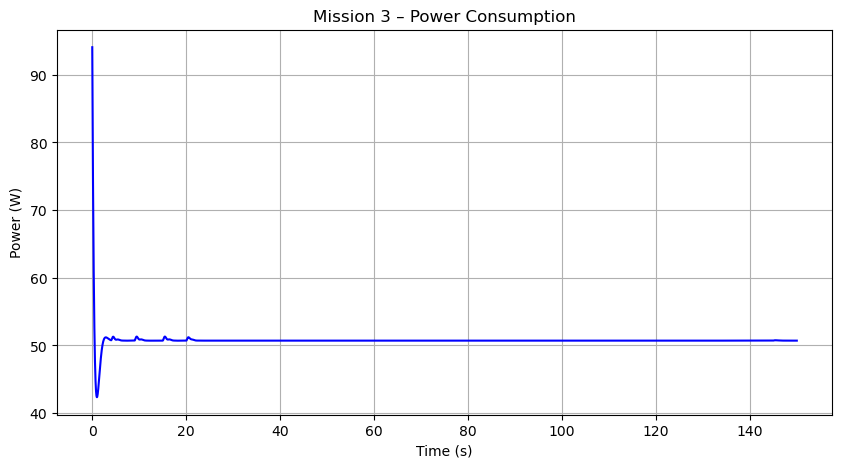

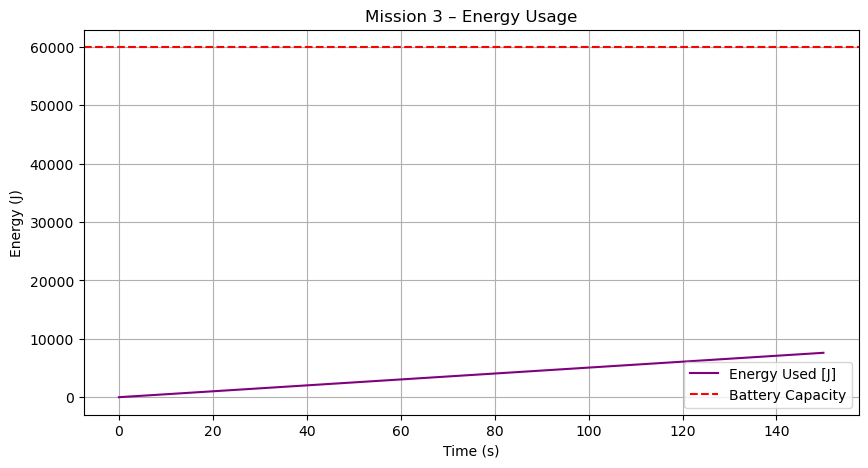

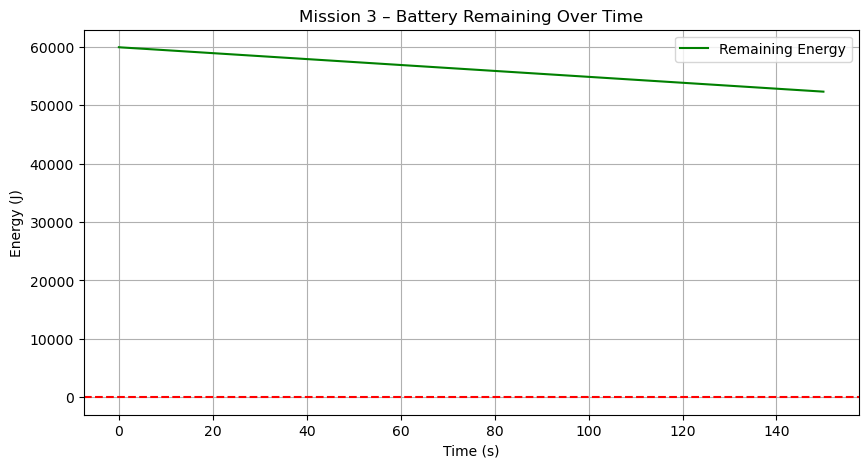

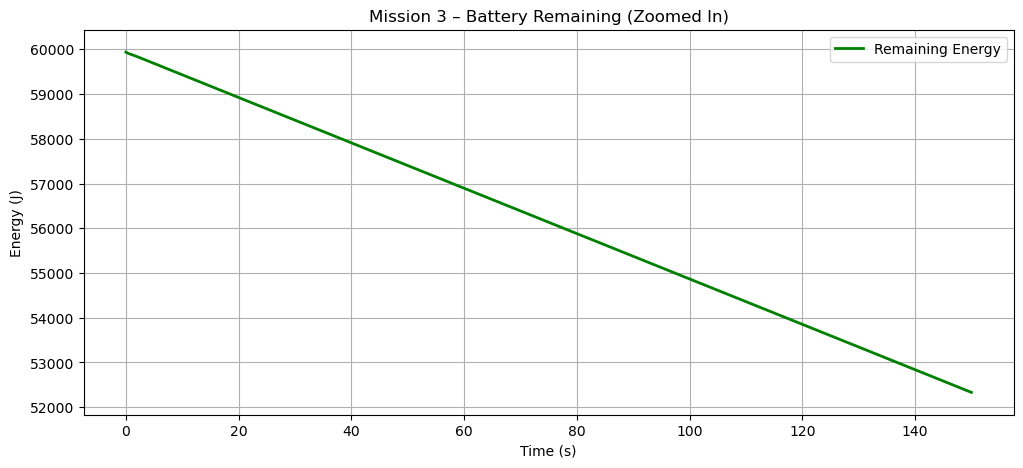

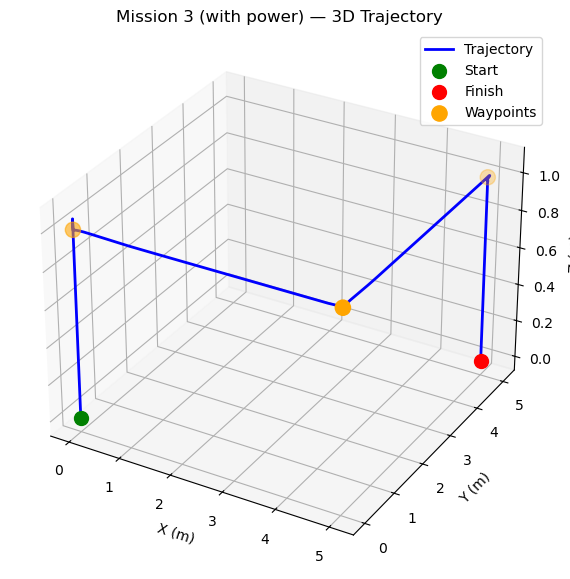

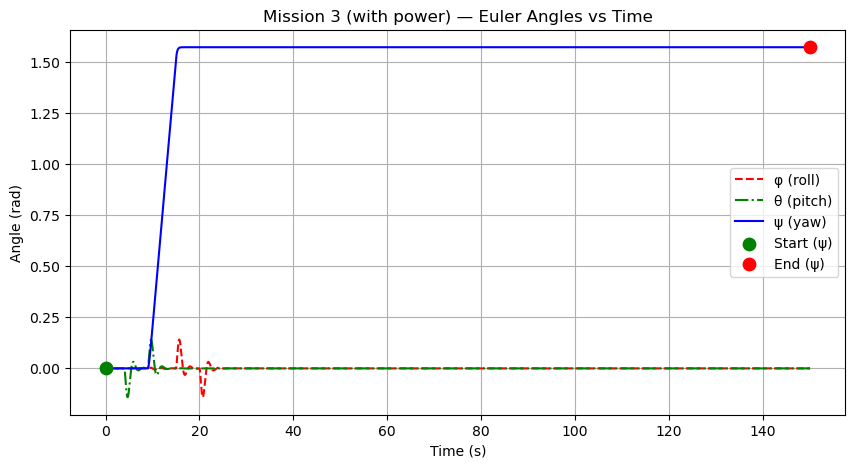

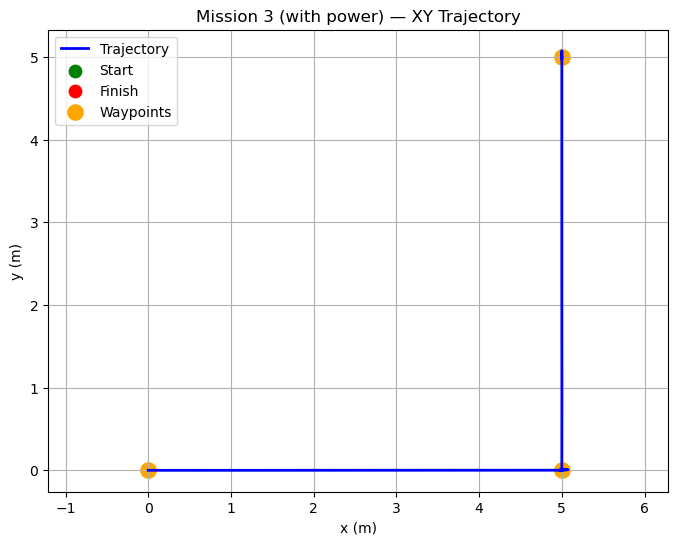

In [23]:
# %% [markdown]
# =====================================
#   MISSION 3 — POWER & TRAJECTORY PLOTS (WITH POWER)
# =====================================

# -------- POWER CONSUMPTION --------
plt.figure(figsize=(10,5))
plt.plot(times_m3_p, Powers_m3, color='blue')
plt.ylabel("Power (W)")
plt.xlabel("Time (s)")
plt.title("Mission 3 – Power Consumption")
plt.grid(True)
plt.show()

# -------- ENERGY USED VS BATTERY --------
E_batt = params["battery_energy_J"]

plt.figure(figsize=(10,5))
plt.plot(times_m3_p, Energies_m3, label="Energy Used [J]", color='purple')
plt.axhline(E_batt, color='red', linestyle='--', label="Battery Capacity")
plt.ylabel("Energy (J)")
plt.xlabel("Time (s)")
plt.title("Mission 3 – Energy Usage")
plt.grid(True)
plt.legend()
plt.show()

# -------- BATTERY REMAINING --------
batt_remaining_m3 = np.maximum(E_batt - Energies_m3, 0)

plt.figure(figsize=(10,5))
plt.plot(times_m3_p, batt_remaining_m3, color='green', label="Remaining Energy")
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Energy (J)")
plt.xlabel("Time (s)")
plt.title("Mission 3 – Battery Remaining Over Time")
plt.grid(True)
plt.legend()
plt.show()

# -------- BATTERY REMAINING (ZOOMED) --------
plt.figure(figsize=(12,5))
plt.plot(times_m3_p, batt_remaining_m3, color='green', linewidth=2)

plt.title("Mission 3 – Battery Remaining (Zoomed In)")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.ylim(batt_remaining_m3.min() - 500, batt_remaining_m3.max() + 500)
plt.grid(True)
plt.legend(["Remaining Energy"])
plt.show()

# -------- 3D TRAJECTORY (START/FINISH/WAYPOINTS) --------
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

X = Xs_m3_p[:,0]
Y = Xs_m3_p[:,1]
Z = Xs_m3_p[:,2]

ax.plot(X, Y, Z, linewidth=2, label="Trajectory", color='blue')

# start & finish
ax.scatter(X[0],  Y[0],  Z[0],  s=100, color='green', label="Start")
ax.scatter(X[-1], Y[-1], Z[-1], s=100, color='red',   label="Finish")

# orange waypoints
wp_x = [0, 5, 5]
wp_y = [0, 0, 5]
wp_z = [1, 1, 1]
ax.scatter(wp_x, wp_y, wp_z, s=120, color='orange', label="Waypoints")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Mission 3 (with power) — 3D Trajectory")
ax.legend()
plt.show()

# -------- EULER ANGLES VS TIME (WITH START/END ON YAW) --------
plt.figure(figsize=(10,5))

phi   = Angles_m3_p[:,0]
theta = Angles_m3_p[:,1]
psi   = Angles_m3_p[:,2]

plt.plot(times_m3_p, phi,   'r--', label="φ (roll)")
plt.plot(times_m3_p, theta, 'g-.', label="θ (pitch)")
plt.plot(times_m3_p, psi,   'b-',  label="ψ (yaw)")

# mark yaw start/end
plt.scatter(times_m3_p[0],  psi[0],  color='green', s=80, zorder=5, label="Start (ψ)")
plt.scatter(times_m3_p[-1], psi[-1], color='red',   s=80, zorder=5, label="End (ψ)")

plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Mission 3 (with power) — Euler Angles vs Time")
plt.grid(True)
plt.legend()
plt.show()

# -------- XY TRAJECTORY (TOP-DOWN, WITH POWER) --------
plt.figure(figsize=(8,6))

X = Xs_m3_p[:,0]
Y = Xs_m3_p[:,1]

plt.plot(X, Y, color='blue', linewidth=2, label="Trajectory")
plt.scatter(X[0],  Y[0],  color='green', s=80, label="Start")
plt.scatter(X[-1], Y[-1], color='red',   s=80, label="Finish")

# orange waypoints
wp_x = [0, 5, 5]
wp_y = [0, 0, 5]
plt.scatter(wp_x, wp_y, color='orange', s=120, label="Waypoints")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Mission 3 (with power) — XY Trajectory")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


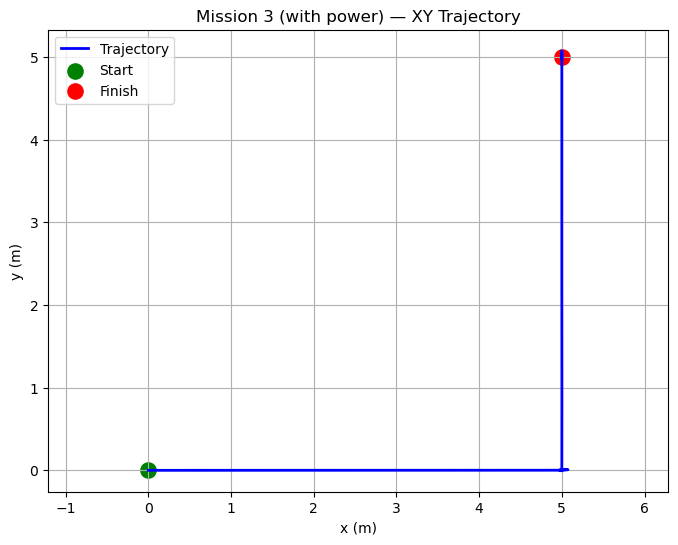

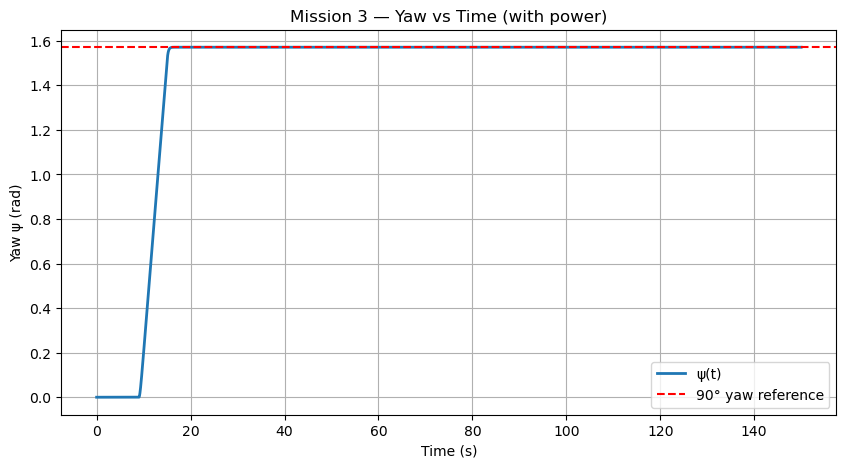

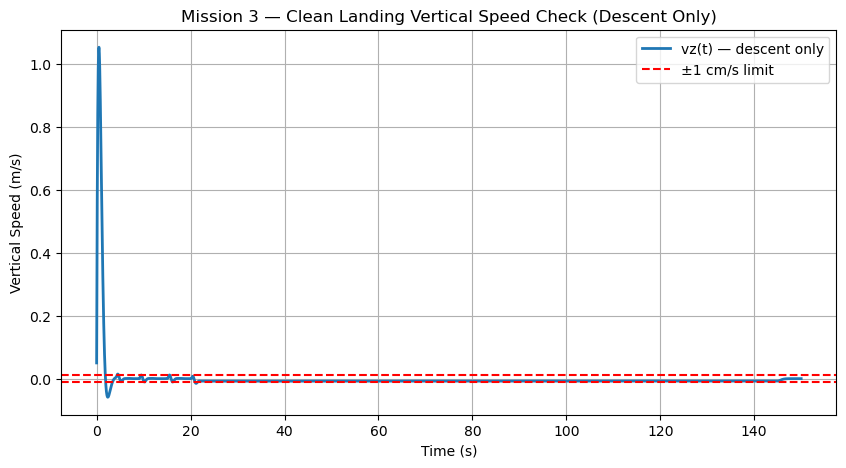

In [24]:
# ============================================================
#   MISSION 3 — REQUESTED PLOTS (WITH POWER MODEL)
# ============================================================

# ------------------------------------------------------------
# 1) FULL XY TRAJECTORY (GREEN START, RED END)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))

X = Xs_m3_p[:,0]
Y = Xs_m3_p[:,1]

plt.plot(X, Y, color='blue', linewidth=2, label="Trajectory")

plt.scatter(X[0],  Y[0],  s=120, color='green', label="Start")
plt.scatter(X[-1], Y[-1], s=120, color='red',   label="Finish")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Mission 3 (with power) — XY Trajectory")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


# ------------------------------------------------------------
# 2) YAW VS TIME (Red dashed 90-degree reference line)
# ------------------------------------------------------------
plt.figure(figsize=(10,5))

psi = Angles_m3_p[:,2]

plt.plot(times_m3_p, psi, label="ψ(t)", linewidth=2)
plt.axhline(np.pi/2, linestyle='--', color='red', label="90° yaw reference")

plt.xlabel("Time (s)")
plt.ylabel("Yaw ψ (rad)")
plt.title("Mission 3 — Yaw vs Time (with power)")
plt.grid(True)
plt.legend()
plt.show()


# ------------------------------------------------------------
# 3) DESCENT-ONLY VERTICAL SPEED PLOT
# ------------------------------------------------------------

# Find descent segment automatically
z_values = Xs_m3_p[:,2]
descent_start_idx = np.where(z_values < 0.99)[0][0]   # first time it starts dropping

descent_times = times_m3_p[descent_start_idx:]
descent_vz    = Vels_m3_p[descent_start_idx:, 2]

plt.figure(figsize=(10,5))
plt.plot(descent_times, descent_vz, label="vz(t) — descent only", linewidth=2)

# ±1 cm/s safety bounds
plt.axhline(0.01,  linestyle='--', color='red', label="±1 cm/s limit")
plt.axhline(-0.01, linestyle='--', color='red')

plt.xlabel("Time (s)")
plt.ylabel("Vertical Speed (m/s)")
plt.title("Mission 3 — Clean Landing Vertical Speed Check (Descent Only)")
plt.grid(True)
plt.legend()
plt.show()
